In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

# Getting Toronto's borough and neighbourhood from wiki 

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
soup = BeautifulSoup(source, 'html5lib')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [3]:
df.head(10)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [4]:
df.shape

(103, 3)

# Getting geocoordinate of Toronto borough and neighbourhood

In [5]:
toronto_geocsv = 'https://cocl.us/Geospatial_data'
!wget -q -O 'toronto_m.geospatial_data.csv' toronto_geocsv
geocsv_data = pd.read_csv(toronto_geocsv)
geocsv_data.head()

'wget' is not recognized as an internal or external command,
operable program or batch file.


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
df = pd.merge(geocsv_data, df, on='Postal Code')
df.head()

,Postal Code,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [7]:
df = df[['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
print(df.shape)
df.head(11)

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


# Segmenting and Clustering Neighborhoods in Toronto

In [8]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


### Create a map of Toronto

In [9]:
address = 'Toronto, TOR'
geolocator = Nominatim(user_agent="TOR_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.7370584, -79.2442535.


In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
map_toronto

### Foursquare call for venues in Toronto

In [11]:
CLIENT_ID = '03JKL4IDKVOJCF1ZR2B1OQOZHKUPMCQ0JYPHCOURERO0AU05' # your Foursquare ID
CLIENT_SECRET = 'FW1ZZZ23UEQLJV2E4JVISE3R4M4DUDHKO22AC4E2TWBZTNXA' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: Hidden')
print('CLIENT_SECRET: Hidden')

Your credentails:
CLIENT_ID: Hidden
CLIENT_SECRET: Hidden


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([( name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [13]:
Toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                       latitudes=df['Latitude'],
                                       longitudes=df['Longitude']
                                      )

In [14]:
print(Toronto_venues.shape)
Toronto_venues.head()

(3370, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,"Malvern, Rouge",43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
2,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
3,"Malvern, Rouge",43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank
4,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant


In [15]:
Toronto_venues.to_csv(r'C:\Users\Joel\Desktop\Joel\Data Science\TorontoVenues.csv', index = False)

In [16]:
Toronto_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
ATM,2,2,2,2,2,2
Accessories Store,2,2,2,2,2,2
Afghan Restaurant,2,2,2,2,2,2
Airport,2,2,2,2,2,2
Airport Lounge,1,1,1,1,1,1
American Restaurant,26,26,26,26,26,26
Amphitheater,1,1,1,1,1,1
Animal Shelter,1,1,1,1,1,1
Antique Shop,2,2,2,2,2,2


## Defining what venue are considered food establishment

In [17]:
terms = ['Bakery', 'Restaurant', 'Burger', 'Pizza', 'Cafe', 'Coffee', 'Bar', 'Wine', 'BBQ', 'Brewery', 'Burrito']
FoodDF = Toronto_venues[Toronto_venues['Venue Category'].str.contains('|'.join(terms))]

In [18]:
FoodDF.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,"Malvern, Rouge",43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
2,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
4,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
5,"Malvern, Rouge",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
7,"Malvern, Rouge",43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop


In [19]:
FoodDF.shape

(1457, 7)

In [20]:
FoodDFClean = FoodDF.groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])['Venue Category'].count().reset_index()
FoodDFClean2 = FoodDFClean.rename(columns={'Venue Category': 'Venue Count'})
FoodDFClean2.sort_values(by='Venue Count').head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Count
44,"Humberlea, Emery",43.724766,-79.532242,1
47,Islington Avenue,43.667856,-79.532242,1
52,Lawrence Park,43.728020,-79.388790,1
14,"Clairville, Humberwood, Woodbine Downs, West H...",43.706748,-79.594054,1
72,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,2


In [21]:
FoodDFClean2.shape

(101, 4)

In [43]:
FoodDFClean2GB = FoodDFClean2.groupby(("Venue Count"), as_index=False)["Neighborhood"].nunique()

In [45]:
FoodDFClean2GB.head()

,Venue Count,Neighborhood
0,1,4
1,2,7
2,3,3
3,4,6
4,5,5


## Heatmap of Food Joints in Toronto

In [23]:
from folium import plugins
from folium.plugins import HeatMap

# Filter the DF for rows, then columns, then remove NaNs
FoodDF2 = FoodDF[['Venue Latitude', 'Venue Longitude']]

# List comprehension to make out list of lists
FoodHeat = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in FoodDF2.iterrows()]

# Plot it on the map
HeatMap(FoodHeat, name=HeatMap, min_opacity=0.5, max_zoom=18, radius=10, blur=10, gradient=None, overlay=True, control=True, show=True).add_to(map_toronto)

# Display the map
map_toronto

## Segmenting Neighbourhood based on venues count

### Finding the histogram of venues counts to split the neighbourhood according to freq%

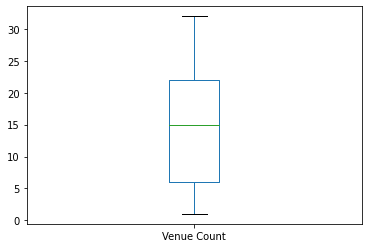

In [24]:
VenueCountHist = FoodDFClean2.boxplot(column =['Venue Count'], grid = False)

In [25]:
print('The neighbourhood will be splitted into 4 segment, <=25%, 25%><50%, 50><75% and >=75%')
FoodDFClean2.describe()

The neighbourhood will be splitted into 4 segment, <=25%, 25%><50%, 50><75% and >=75%


,Neighborhood Latitude,Neighborhood Longitude,Venue Count
count,101.000000,101.000000,101.000000
mean,43.702782,-79.399271,14.425743
std,0.051021,0.096176,8.838944
min,43.602414,-79.615819,1.000000
25%,43.659526,-79.464763,6.000000
50%,43.696319,-79.389494,15.000000
75%,43.739416,-79.340923,22.000000
max,43.815252,-79.160497,32.000000


### Clustering Neighbourhood based on Venues Count

In [26]:
from sklearn.cluster import KMeans
import sklearn.cluster.k_means_
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1, 
  verbose=True)

C:\Users\Joel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [27]:
k=4
torontofood_clustering = FoodDFClean2.drop(['Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(torontofood_clustering)
kmeans.labels_
FoodDFClean2.insert(0, 'Cluster Labels', kmeans.labels_)

In [28]:
FoodDFClean3 = FoodDFClean2
FoodDFClean3.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Count
0,1,Agincourt,43.794200,-79.262029,23
1,3,"Alderwood, Long Branch",43.602414,-79.543484,4
2,0,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,8
3,3,Bayview Village,43.786947,-79.385975,4
4,2,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,18


In [29]:
FoodDFClean3Drop = FoodDFClean3.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude'])

In [30]:
FoodDFGroup = FoodDFClean3Drop.groupby(['Cluster Labels'], as_index=False)['Neighborhood','Venue Count'].agg(lambda x: list(x))

<ipython-input-30-645c2d368fd6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  FoodDFGroup = FoodDFClean3Drop.groupby(['Cluster Labels'], as_index=False)['Neighborhood','Venue Count'].agg(lambda x: list(x))


In [31]:
FoodDFGroup

,Cluster Labels,Neighborhood,Venue Count
0,0,"[Bathurst Manor, Wilson Heights, Downsview Nor...","[8, 8, 10, 11, 14, 9, 9, 13, 8, 10, 14, 8, 8, ..."
1,1,"[Agincourt, Brockton, Parkdale Village, Exhibi...","[23, 25, 26, 27, 25, 24, 28, 23, 25, 28, 32, 2..."
2,2,"[Bedford Park, Lawrence Manor East, Berczy Par...","[18, 19, 15, 20, 21, 18, 20, 18, 21, 22, 21, 2..."
3,3,"[Alderwood, Long Branch, Bayview Village, Birc...","[4, 4, 2, 2, 1, 5, 2, 2, 3, 3, 2, 1, 1, 4, 1, ..."


In [32]:
FoodDFClean3['Cluster Labels'].value_counts()

2    29
3    27
1    24
0    21
Name: Cluster Labels, dtype: int64

In [39]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(FoodDFClean2['Neighborhood Latitude'], FoodDFClean2['Neighborhood Longitude'], FoodDFClean2['Neighborhood'], FoodDFClean2['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + str(cluster), parse_html=True)
    popup=label,
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### List of neighbourhood with minimum food venue count

In [59]:
LowestCountN = FoodDFClean2[ FoodDFClean2['Venue Count'] == FoodDFClean2['Venue Count'].min() ]
LowestCountN.reset_index(drop=True)

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Count
0,3,"Clairville, Humberwood, Woodbine Downs, West H...",43.706748,-79.594054,1
1,3,"Humberlea, Emery",43.724766,-79.532242,1
2,3,Islington Avenue,43.667856,-79.532242,1
3,3,Lawrence Park,43.728020,-79.388790,1


In [65]:
print(LowestCountN['Neighborhood'].tolist())

['Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale', 'Humberlea, Emery', 'Islington Avenue', 'Lawrence Park']


In [64]:
# create map
map_clusters2 = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(LowestCountN['Neighborhood Latitude'], LowestCountN['Neighborhood Longitude'], LowestCountN['Neighborhood'], LowestCountN['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + str(cluster), parse_html=True)
    popup=label,
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5).add_to(map_clusters2)
       
map_clusters2

## Analysis of Each Neighbourhood

In [34]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

In [35]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [36]:
num_top_venues = 5
for neigh in Toronto_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.14
1         Shopping Mall  0.11
2                Bakery  0.05
3  Caribbean Restaurant  0.05
4          Noodle House  0.02


----Alderwood, Long Branch----
            venue  freq
0  Discount Store  0.12
1     Pizza Place  0.08
2            Park  0.08
3   Shopping Mall  0.04
4    Liquor Store  0.04


----Bathurst Manor, Wilson Heights, Downsview North----
               venue  freq
0  Convenience Store  0.06
1               Park  0.06
2        Coffee Shop  0.06
3               Bank  0.06
4        Bridal Shop  0.03


----Bayview Village----
                 venue  freq
0                 Bank  0.12
1  Japanese Restaurant  0.12
2        Grocery Store  0.12
3          Gas Station  0.12
4                 Park  0.06


----Bedford Park, Lawrence Manor East----
                  venue  freq
0    Italian Restaurant  0.07
1           Coffee Shop  0.07
2                  Bank  0.05
3  Fast Food Restaurant  0.05
4        Sa

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
import numpy as np
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Caribbean Restaurant,Bakery,Bank,Seafood Restaurant,Sushi Restaurant,Discount Store,Supermarket,Intersection
1,"Alderwood, Long Branch",Discount Store,Park,Pizza Place,Pharmacy,Gas Station,Shopping Mall,Liquor Store,Donut Shop,Moroccan Restaurant,Sandwich Place
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Convenience Store,Park,Coffee Shop,Supermarket,Sushi Restaurant,Bridal Shop,Sandwich Place,Fried Chicken Joint,Deli / Bodega
3,Bayview Village,Bank,Japanese Restaurant,Grocery Store,Gas Station,Playground,Park,Skating Rink,Café,Intersection,Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Bank,Fast Food Restaurant,Pub,Bagel Shop,Bakery,Indian Restaurant,Intersection
